# Data Analysis Script for c57 with father group

## Overview
This Python script analyzes cFos data from experiments on c57 mice reared with father, comparing experimental groups through various metrics, including cell count and energy levels. It uses statistical analyses to identify significant brain areas and creates visualizations to interpret the results.

## Configuration Variables
- `root_directory`: Main directory for data.
- `experiment`: Name of the experiment.
- `experimental_group`: Experimental group.
- `data_directory`: Data directory.
- `subjects`: List of subjects.
- `threshold`: Thresholds for data analysis.

## Analysis and Visualizations

1. **Loading and Preprocessing Data**
   - Loads volumes and data for each subject.
   - Removes areas with null cell counts or no volume.

2. **Dividing Subjects into Experimental Groups**
   - Divides subjects into groups: CONTROL, FATHER URINE EXPOSURE, CD1 URINE EXPOSURE.

3. **Cell Count Analysis**
   - Calculates cell count per area and group.
   - Performs statistical tests to compare groups.
   - Computes and visualizes the cross-correlation matrix for each group.

4. **Energy Analysis**
   - Calculates and compares energy levels per area and group.
   - Performs statistical tests and visualizes cross-correlation matrices.

5. **Visualizations**
   - Creates bar plots and heatmaps to visualize significant differences between experimental groups.

## Additional Notes
- The code is designed to process data stored in CSV files and save them in `.npy` format for analysis.
- Also includes ANOVA tests to compare various metrics between experimental groups.



In [2]:
# !pip install odfpy
# !pip install seaborn
import os
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import yaml
from yaml import Loader
import numpy as np
import analyze_cells_energy as ace
import utils
from scipy.stats import ttest_ind, mannwhitneyu
import networkx as nx
import matplotlib.pyplot as plt

In [3]:
root_directory = '/home/stella/Documents/Torino/projects/'
experiment = 'SexualImprinting'
experimental_group = 'C57_MaleUrine_Exposure_cFos'
data_directory = root_directory + experiment + '/' \
                + experimental_group + '/'
subjects = [name for name in os.listdir(data_directory) \
            if os.path.isdir(os.path.join(data_directory, name))]
threshold = (300, 2500)

In [4]:
# load query file where we added volumes for each area
volumes = ace.clean_volumes_database()

/home/stella/anaconda2/envs/ClearMap/lib/python3.6/site-packages/openpyxl/worksheet/_reader.py:329: UserWarning: Unknown extension is not supported and will be removed
  warn(msg)


In [5]:
def load_subject(subject, data_directory, threshold1hemisphere, threshold2hemispheres, 
                 thresholdF6Unfam, thresholdBL48Unfam):
    if subject[0] == 'F':
        if subject =='F6Unfam':
            file_suffix = 'cells_' + str(thresholdF6Unfam)
        else:
            file_suffix = 'cells_' + str(threshold1hemisphere)
    else:
        if subject == 'BL48Unfam':
            file_suffix = 'cells_' + str(thresholdBL48Unfam)
        else:
            file_suffix = 'cells_' + str(threshold2hemispheres)
            
    df_mouse = pd.read_csv(data_directory + subject + '/' + file_suffix + '.csv')
    if subject[0]=='B':
        df_mouse = ace.reformat_df_mouse(df=df_mouse[df_mouse[' x']>228].reset_index(drop=True))
    else:
        df_mouse = ace.reformat_df_mouse(df=df_mouse)
    
    return df_mouse

In [6]:
def find_significant_areas(dictionary, experimental_groups, value, test='mannwhitneyu', alpha=0.05):
    dfs = \
    ace.calculate_value_across_groups(experimental_groups=experimental_groups, 
                                  dict_results_across_mice=dictionary, 
                                  value=value)
    df_ttest = ace.test_across_groups(dfs,
                                     test=test,
                                     groups=list(experimental_groups.keys()))
    # sort dataframe pvalues of control vs fam and pick the first 20
    columns = df_ttest.loc[:, df_ttest.columns!='area'].columns
    df_sigareas = pd.DataFrame()
    for col in columns:
        df = df_ttest.sort_values(by=col)[['area', col]]
        df_sigareas = pd.concat([df_sigareas, df[df[col]<alpha]['area'].reset_index(drop=True)], axis=1)
    df_sigareas.columns = [col.replace('pval_', '') for col in columns]
    return df_sigareas

# Analysis on C57 : threshold 300

In [7]:
# dict_results_across_mice = {subject: ace.calculate_cells_energy_per_level(df_mouse=load_subject(subject=subject, 
#                                                                                                 data_directory=data_directory, 
#                                                                                                 threshold1hemisphere=300, 
#                                                                                                 threshold2hemispheres=2500,
#                                                                                                 thresholdF6Unfam=600,
#                                                                                                 thresholdBL48Unfam=3000), 
#                                                                           vol=volumes, 
#                                                                           level=8) for subject in subjects}
# np.save('dict_results/newvolumes/dict_results_across_mice_c57_merged_hemispheres_F6BL48.npy', dict_results_across_mice)

In [8]:
dict_results_across_mice = np.load('dict_results/newvolumes/dict_results_across_mice_c57_merged_hemispheres_F6BL48.npy', 
                                   allow_pickle=True).item()

In [9]:
dict_results_across_mice['BL48Unfam']


,area,n_cells,energy,density,relative_density
0,Frontal pole cerebral cortex,43,8.227511e+05,78.823378,0.983473
1,Primary motor area,1893,3.287109e+06,319.731165,3.989262
2,Secondary motor area,1462,2.008656e+06,213.805043,2.667630
3,Primary somatosensory area,4369,3.466041e+06,349.073840,4.355369
4,Supplemental somatosensory area,806,1.610156e+06,170.815300,2.131250
...,...,...,...,...,...
194,Interfascicular nucleus raphe,5,3.541568e+05,49.278784,0.614848
195,Interpeduncular nucleus,8,1.421729e+05,20.791597,0.259415
196,Rostral linear nucleus raphe,3,6.820057e+05,44.502820,0.555258
197,Central linear nucleus raphe,7,5.684016e+05,73.617616,0.918522


In [10]:
subjects = list(dict_results_across_mice.keys())

# List areas with null cell count

In [11]:
db_null_count = {subject: dict_results_across_mice[subject][
    dict_results_across_mice[subject].n_cells == 0] for subject in subjects}

# List areas with no volume

In [12]:
db_null_volume = {subject: dict_results_across_mice[subject][
    dict_results_across_mice[subject]['energy'].isnull()] for subject in subjects}

# Divide mice into experimental groups: FAM/UNFAM/CONTROL

In [13]:
experimental_groups = utils.divide_in_exp_groups(list_subjects=subjects)

# Calculate cell count across experimental groups

In [14]:
df_control_cell_count, df_fam_cell_count, df_unfam_cell_count = \
ace.calculate_value_across_groups(experimental_groups=experimental_groups, 
                              dict_results_across_mice=dict_results_across_mice, 
                              value='n_cells')

In [16]:
df_control_cell_count

,area,BL53Control,F10Control,BL45Control,F16Control,BL51Control,F11Control,F1Control
0,Frontal pole cerebral cortex,25,59,68,23,32,106,105
1,Primary motor area,858,1447,558,41,1143,155,259
2,Secondary motor area,1014,2448,711,219,1297,587,1448
3,Primary somatosensory area,2047,2755,2584,444,1885,377,1442
4,Supplemental somatosensory area,611,1055,713,122,882,403,493
...,...,...,...,...,...,...,...,...
194,Interfascicular nucleus raphe,4,1,2,0,6,0,0
195,Interpeduncular nucleus,13,3,30,0,42,0,0
196,Rostral linear nucleus raphe,5,0,2,0,5,0,0
197,Central linear nucleus raphe,6,1,15,0,10,0,0


In [15]:
df_fam_cell_count.set_index('area').sum()

BL49Fam    40180
F7Fam      50726
F15Fam     28414
BL47Fam    45959
F13Fam     25668
F5Fam      26756
BL50Fam    49253
F3Fam      42793
F9Fam      67115
dtype: int64

In [16]:
df_unfam_cell_count.set_index('area').sum()

F6Unfam      69530
F8Unfam      68881
BL48Unfam    40979
F4Unfam      36382
F2Unfam      76009
BL54Unfam    25408
BL52Unfam    29065
BL46Unfam    29777
F12Unfam     41229
F14Unfam     20149
dtype: int64

In [19]:
df_control_cell_count.set_index('area').loc['Arcuate hypothalamic nucleus']

BL53Control    10
F10Control      0
BL45Control     8
F16Control      3
BL51Control    16
F11Control      8
F1Control      19
Name: Arcuate hypothalamic nucleus, dtype: int64

In [20]:
df_fam_cell_count.set_index('area').loc['Arcuate hypothalamic nucleus']

BL49Fam     85
F7Fam      267
F15Fam     248
BL47Fam     81
F13Fam      94
F5Fam       27
BL50Fam     30
F3Fam      304
F9Fam        7
Name: Arcuate hypothalamic nucleus, dtype: int64

In [21]:
df_unfam_cell_count.set_index('area').loc['Arcuate hypothalamic nucleus']

F6Unfam      212
F8Unfam      193
BL48Unfam      6
F4Unfam      143
F2Unfam      375
BL54Unfam     11
BL52Unfam     46
BL46Unfam      1
F12Unfam     106
F14Unfam     165
Name: Arcuate hypothalamic nucleus, dtype: int64

In [19]:
df_control_cell_count.set_index('area').loc['Medial amygdalar nucleus']

BL53Control     89
F10Control     372
BL45Control    208
F16Control     108
BL51Control    210
F11Control      70
F1Control      271
Name: Medial amygdalar nucleus, dtype: int64

In [20]:
df_fam_cell_count.set_index('area').loc['Medial amygdalar nucleus']

BL49Fam    1031
F7Fam      1547
F15Fam      948
BL47Fam     624
F13Fam      838
F5Fam       462
BL50Fam     777
F3Fam      1148
F9Fam      1232
Name: Medial amygdalar nucleus, dtype: int64

In [21]:
df_unfam_cell_count.set_index('area').loc['Medial amygdalar nucleus']

F6Unfam      1107
F8Unfam      1986
BL48Unfam     379
F4Unfam       961
F2Unfam      1385
BL54Unfam     490
BL52Unfam     261
BL46Unfam     373
F12Unfam      967
F14Unfam      795
Name: Medial amygdalar nucleus, dtype: int64

In [22]:
df_control_cell_count.set_index('area').loc['Basomedial amygdalar nucleus']

BL53Control    143
F10Control     326
BL45Control    261
F16Control     165
BL51Control    131
F11Control     197
F1Control      238
Name: Basomedial amygdalar nucleus, dtype: int64

In [23]:
df_fam_cell_count.set_index('area').loc['Basomedial amygdalar nucleus']

BL49Fam    324
F7Fam      572
F15Fam     296
BL47Fam    408
F13Fam     278
F5Fam      192
BL50Fam    376
F3Fam      412
F9Fam      571
Name: Basomedial amygdalar nucleus, dtype: int64

In [24]:
df_unfam_cell_count.set_index('area').loc['Basomedial amygdalar nucleus']

F6Unfam      431
F8Unfam      680
BL48Unfam    337
F4Unfam      465
F2Unfam      532
BL54Unfam    253
BL52Unfam    271
BL46Unfam    186
F12Unfam     326
F14Unfam     301
Name: Basomedial amygdalar nucleus, dtype: int64

In [25]:
df_control_cell_count.set_index('area').loc['Supramammillary nucleus']

BL53Control    32
F10Control     66
BL45Control    61
F16Control      3
BL51Control    36
F11Control     25
F1Control      20
Name: Supramammillary nucleus, dtype: int64

In [26]:
df_fam_cell_count.set_index('area').loc['Supramammillary nucleus']

BL49Fam    56
F7Fam      56
F15Fam     34
BL47Fam    47
F13Fam     44
F5Fam       8
BL50Fam    71
F3Fam      50
F9Fam      17
Name: Supramammillary nucleus, dtype: int64

In [27]:
df_unfam_cell_count.set_index('area').loc['Supramammillary nucleus']

F6Unfam       57
F8Unfam      207
BL48Unfam     22
F4Unfam       76
F2Unfam      199
BL54Unfam     27
BL52Unfam     62
BL46Unfam     31
F12Unfam      62
F14Unfam      59
Name: Supramammillary nucleus, dtype: int64

## Calculate t-tests across groups per area

In [28]:
df_ttest_ncells = ace.test_across_groups([df_control_cell_count,df_fam_cell_count,df_unfam_cell_count], 
                                         test='mannwhitneyu')

In [29]:
# remove rows corresponding to area that have zero cell count across all experimental groups
df_ttest_not_null_ncells = df_ttest_ncells.dropna(axis=0,
                                   how='all',
                                   subset=['pval_Control_vs_Fam',
                                          'pval_Control_vs_Unfam',
                                          'pval_Fam_vs_Unfam'])

In [31]:
# sort dataframe pvalues of control vs fam and pick the first 20
df_ttest_not_null_ncells.sort_values(by='pval_Control_vs_Fam')[['area', 'pval_Control_vs_Fam']][0:40].set_index('area')

,pval_Control_vs_Fam
area,
Ventral premammillary nucleus,0.000512082
Medial amygdalar nucleus,0.000516488
Posterior amygdalar nucleus,0.000516488
Cortical amygdalar area,0.000747798
Tuberal nucleus,0.00151916
Posterodorsal preoptic nucleus,0.00179599
Periventricular hypothalamic nucleus posterior part,0.00211763
Bed nuclei of the stria terminalis,0.00213172
Piriform-amygdalar area,0.00213172


In [32]:
# sort dataframe pvalues of control vs unfam and pick the first 20
df_ttest_not_null_ncells.sort_values(by='pval_Control_vs_Unfam')[['area', 'pval_Control_vs_Unfam']][0:35].set_index('area')

,pval_Control_vs_Unfam
area,
Ventral premammillary nucleus,0.000377316
Periventricular hypothalamic nucleus posterior part,0.000377316
Posterior amygdalar nucleus,0.000380153
Medial amygdalar nucleus,0.000757812
Cortical amygdalar area,0.00145782
Piriform-amygdalar area,0.00145782
Basomedial amygdalar nucleus,0.00556014
Bed nuclei of the stria terminalis,0.00641335
Posterodorsal preoptic nucleus,0.00660642


In [33]:
# sort dataframe pvalues of fam vs unfam and pick the first 20
df_ttest_not_null_ncells.sort_values(by='pval_Fam_vs_Unfam')[['area', 'pval_Fam_vs_Unfam']][0:20].set_index('area')

,pval_Fam_vs_Unfam
area,
Anterodorsal nucleus,0.0225385
Septohippocampal nucleus,0.0510203
Supramammillary nucleus,0.0555165
Fasciola cinerea,0.0696843
Medial habenula,0.0762505
Bed nucleus of the anterior commissure,0.0838818
Vascular organ of the lamina terminalis,0.0938162
Dorsal auditory area,0.102734
Dentate gyrus,0.102834


## Calculate cross corr across groups per area on cell count

In [94]:
corr_matrix_control_ncells = ace.cross_corr(df_control_cell_count)

In [95]:
corr_matrix_control_ncells = ace.cross_corr(df_control_cell_count)
corr_matrix_fam_ncells = ace.cross_corr(df_fam_cell_count)
corr_matrix_unfam_ncells = ace.cross_corr(df_unfam_cell_count)

In [96]:
corr_matrix_unfam_ncells = ace.cross_corr(df_unfam_cell_count)

## Plot cross corr matrix across groups per area on cell count

Text(0.5, 1.0, 'CONTROL')

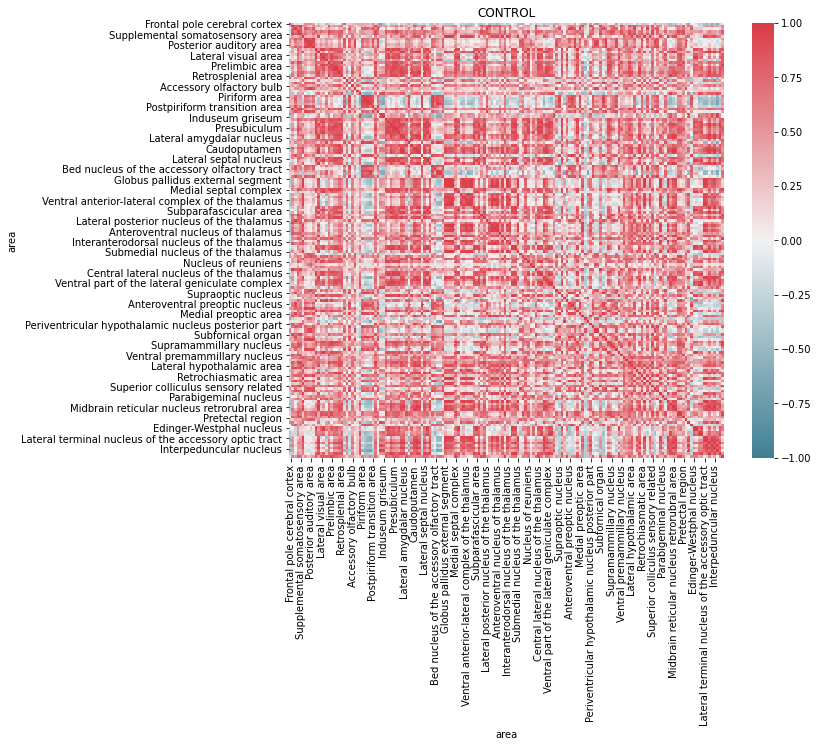

In [97]:
f, ax = plt.subplots(figsize=(10, 8))
sns.heatmap(corr_matrix_control_ncells,
    cmap=sns.diverging_palette(220, 10, as_cmap=True),
    vmin=-1.0, vmax=1.0,
    square=True, ax=ax)
ax.set_title('CONTROL')

Text(0.5, 1.0, 'FAM')

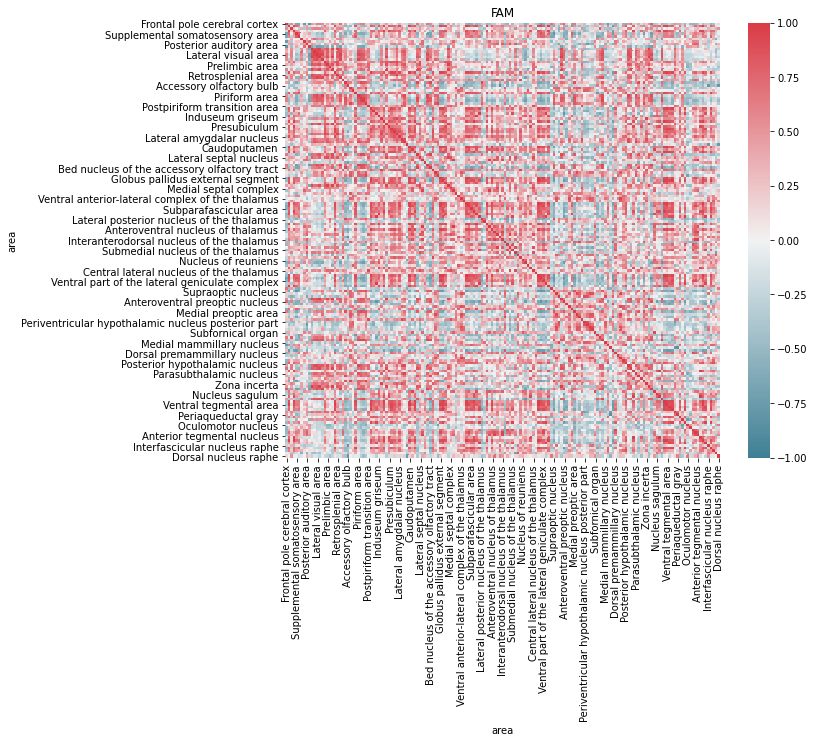

In [98]:
f, ax = plt.subplots(figsize=(10, 8))
sns.heatmap(corr_matrix_fam_ncells,
    cmap=sns.diverging_palette(220, 10, as_cmap=True),
    vmin=-1.0, vmax=1.0,
    square=True, ax=ax)
ax.set_title('FAM')

Text(0.5, 1.0, 'UNFAM')

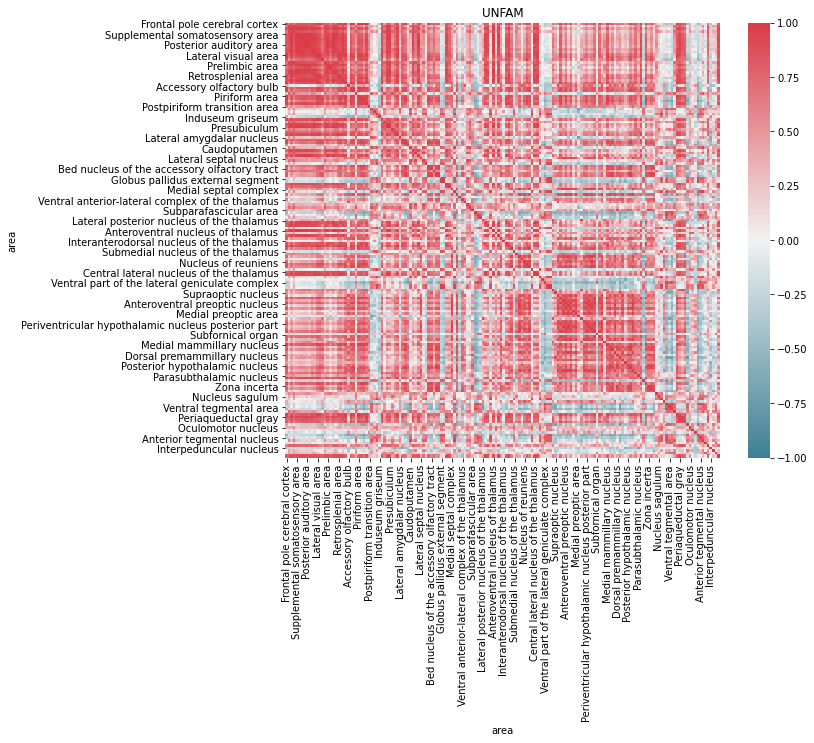

In [99]:
f, ax = plt.subplots(figsize=(10, 8))
sns.heatmap(corr_matrix_unfam_ncells,
    cmap=sns.diverging_palette(220, 10, as_cmap=True),
    vmin=-1.0, vmax=1.0,
    square=True, ax=ax)
ax.set_title('UNFAM')

# Calculate energy across experimental groups

In [100]:
df_control_energy, df_fam_energy, df_unfam_energy = \
ace.calculate_value_across_groups(experimental_groups, dict_results_across_mice, value='energy')

## T-test on energy across groups

In [101]:
df_ttest_energy = ace.test_across_groups([df_control_energy,df_fam_energy,df_unfam_energy],
                                        test='mannwhitneyu')

In [102]:
# remove rows corresponding to area that have zero cell count across all experimental groups
df_ttest_not_null_energy = df_ttest_energy.dropna(axis=0,
                                   how='all',
                                   subset=['pval_Control_vs_Fam',
                                          'pval_Control_vs_Unfam',
                                          'pval_Fam_vs_Unfam'])

In [103]:
# sort dataframe pvalues of control vs fam and pick the first 20
df_ttest_not_null_energy.sort_values(by='pval_Control_vs_Fam')[['area', 'pval_Control_vs_Fam']][0:20].set_index('area')

,pval_Control_vs_Fam
area,
Nucleus circularis,0.000516488
Ventral premammillary nucleus,0.000516488
Pineal body,0.000516488
Anterior hypothalamic area,0.000516488
Lateral strip of striatum,0.000516488
Retroethmoid nucleus,0.000516488
Suprachiasmatic preoptic nucleus,0.000516488
Intercollicular nucleus,0.000516488
Substantia nigra lateral part,0.000516488


In [104]:
# sort dataframe pvalues of control vs fam and pick the first 20
df_ttest_not_null_energy.sort_values(by='pval_Control_vs_Unfam')[['area', 'pval_Control_vs_Unfam']][0:20].set_index('area')

,pval_Control_vs_Unfam
area,
Ventral premammillary nucleus,0.000380153
Periventricular hypothalamic nucleus posterior part,0.00104909
Cortical amygdalar area,0.00105575
Posterodorsal preoptic nucleus,0.00142679
Medial amygdalar nucleus,0.00270696
Posterior amygdalar nucleus,0.00364035
Piriform-amygdalar area,0.00485294
Arcuate hypothalamic nucleus,0.00485294
Medial preoptic nucleus,0.00641335


In [105]:
# sort dataframe pvalues of control vs fam and pick the first 20
df_ttest_not_null_energy.sort_values(by='pval_Fam_vs_Unfam')[['area', 'pval_Fam_vs_Unfam']][0:20].set_index('area')

,pval_Fam_vs_Unfam
area,
Substantia nigra lateral part,0.0152431
Intercollicular nucleus,0.0152431
Suprachiasmatic preoptic nucleus,0.0152431
Anterior hypothalamic area,0.0152431
Nucleus circularis,0.0152431
Pineal body,0.0152431
Retroethmoid nucleus,0.0152431
Lateral strip of striatum,0.0152431
Interanteromedial nucleus of the thalamus,0.0765209


In [106]:
corr_matrix_control_energy = ace.cross_corr(df_control_energy)

In [107]:
corr_matrix_fam_energy = ace.cross_corr(df_fam_energy)

In [108]:
corr_matrix_unfam_energy = ace.cross_corr(df_unfam_energy)

## Plot cross corr matrix across groups per area on energy

Text(0.5, 1.0, 'CONTROL')

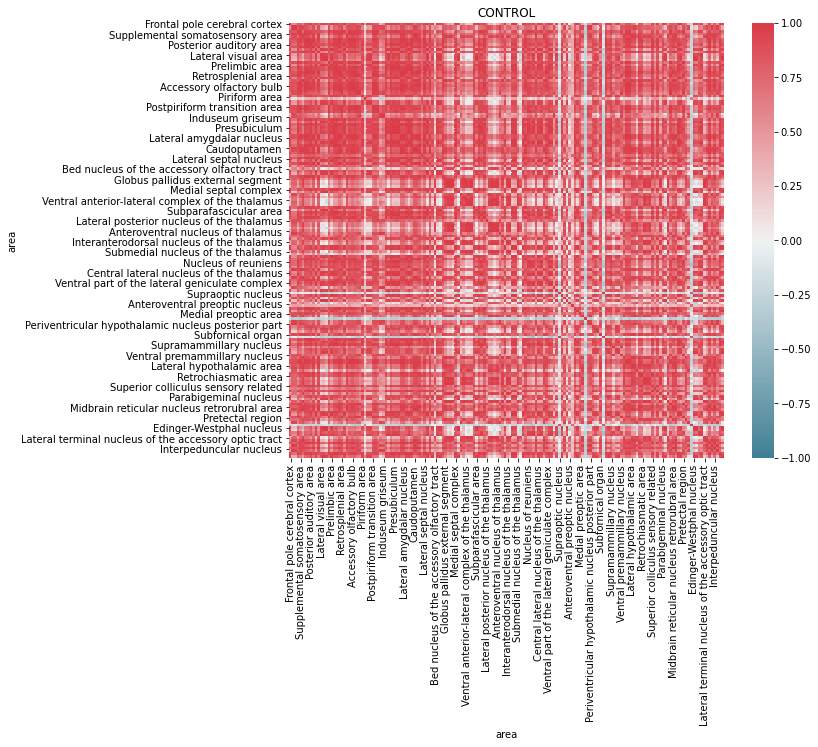

In [109]:
f, ax = plt.subplots(figsize=(10, 8))
sns.heatmap(corr_matrix_control_energy,
    cmap=sns.diverging_palette(220, 10, as_cmap=True),
    vmin=-1.0, vmax=1.0,
    square=True, ax=ax)
ax.set_title('CONTROL')

Text(0.5, 1.0, 'FAM')

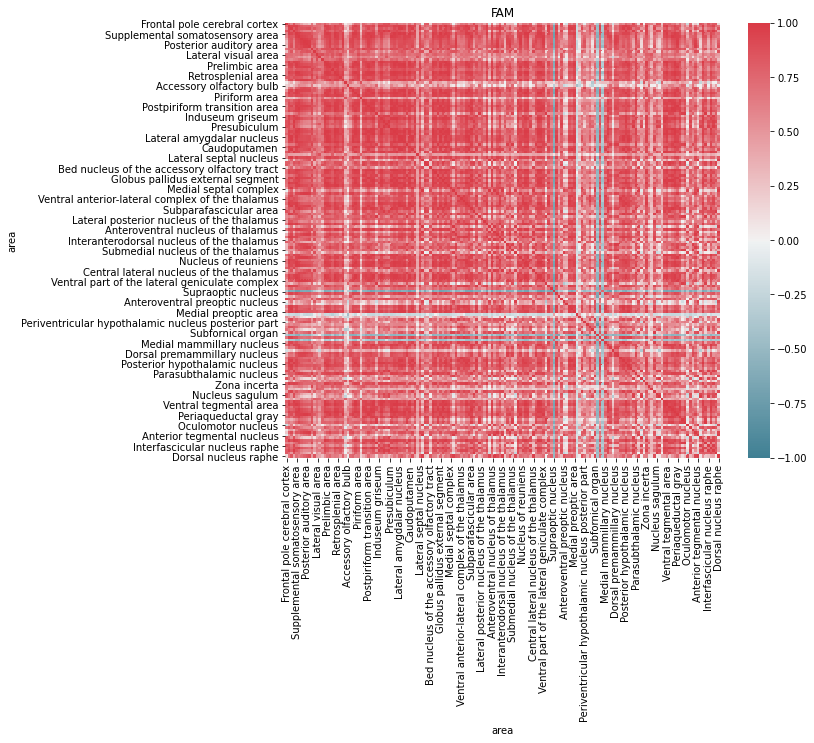

In [110]:
f, ax = plt.subplots(figsize=(10, 8))
sns.heatmap(corr_matrix_fam_energy,
    cmap=sns.diverging_palette(220, 10, as_cmap=True),
    vmin=-1.0, vmax=1.0,
    square=True, ax=ax)
ax.set_title('FAM')

Text(0.5, 1.0, 'UNFAM')

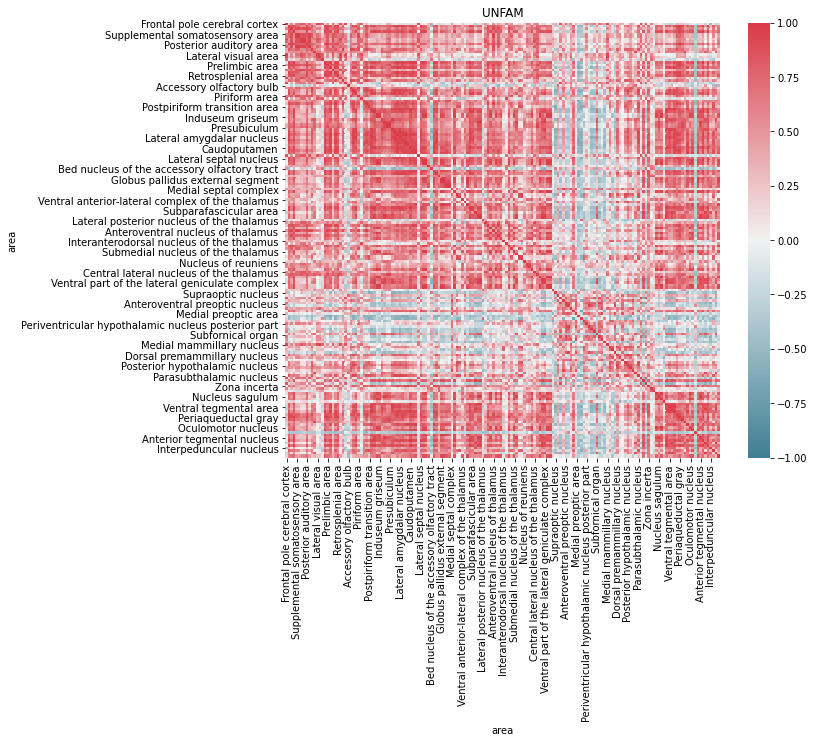

In [111]:
f, ax = plt.subplots(figsize=(10, 8))
sns.heatmap(corr_matrix_unfam_energy,
    cmap=sns.diverging_palette(220, 10, as_cmap=True),
    vmin=-1.0, vmax=1.0,
    square=True, ax=ax)
ax.set_title('UNFAM')

<AxesSubplot:xlabel='area', ylabel='number of cells'>

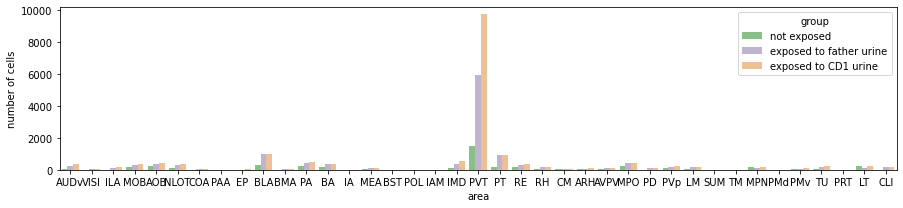

In [112]:
# stack1
areas_ttest = np.unique(np.hstack([
    df_ttest_not_null_ncells[df_ttest_not_null_ncells['pval_Control_vs_Fam']<0.05]['area'].values,
    df_ttest_not_null_ncells[df_ttest_not_null_ncells['pval_Control_vs_Unfam']<0.05]['area'].values,
    df_ttest_not_null_ncells[df_ttest_not_null_ncells['pval_Fam_vs_Unfam']<0.05]['area'].values]))

areas_ttest_acronyms = [volumes[volumes['safe_name']==area]['acronym'].values[0] for area in areas_ttest]
areas_ttest_acronyms = [area for area in volumes['acronym'].values if area in areas_ttest_acronyms]

control = pd.DataFrame(columns=['area', 'number of cells', 'group'])
fam = pd.DataFrame(columns=['area', 'number of cells', 'group'])
unfam = pd.DataFrame(columns=['area', 'number of cells', 'group'])
control['area'] = areas_ttest_acronyms
control['group'] = ['not exposed' for area in areas_ttest]
control['number of cells'] = [df_control_cell_count.set_index('area').loc[area].mean() for area in areas_ttest]

fam['area'] = areas_ttest_acronyms
fam['group'] = ['exposed to father urine' for area in areas_ttest]
fam['number of cells'] = [df_fam_cell_count.set_index('area').loc[area].mean() for area in areas_ttest]

unfam['area'] = areas_ttest_acronyms
unfam['group'] = ['exposed to CD1 urine' for area in areas_ttest]
unfam['number of cells'] = [df_unfam_cell_count.set_index('area').loc[area].mean() for area in areas_ttest]
with_father = control.append(fam).append(unfam)

f, ax = plt.subplots(ncols=1, nrows=1, figsize=(15,3), sharey=True)
sns.barplot(
    data=with_father,
    x="area", y="number of cells", hue="group", palette="Accent", ax=ax)

<AxesSubplot:xlabel='area', ylabel='energy'>

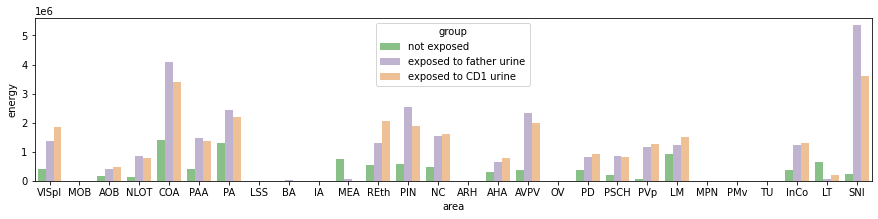

In [113]:
# stack1
areas_ttest = np.unique(np.hstack([
    df_ttest_not_null_energy[df_ttest_not_null_energy['pval_Control_vs_Fam']<0.05]['area'].values,
    df_ttest_not_null_energy[df_ttest_not_null_energy['pval_Control_vs_Unfam']<0.05]['area'].values,
    df_ttest_not_null_energy[df_ttest_not_null_energy['pval_Fam_vs_Unfam']<0.05]['area'].values]))

areas_ttest_acronyms = [volumes[volumes['safe_name']==area]['acronym'].values[0] for area in areas_ttest]
areas_ttest_acronyms = [area for area in volumes['acronym'].values if area in areas_ttest_acronyms]

control = pd.DataFrame(columns=['area', 'energy', 'group'])
fam = pd.DataFrame(columns=['area', 'energy', 'group'])
unfam = pd.DataFrame(columns=['area', 'energy', 'group'])
control['area'] = areas_ttest_acronyms
control['group'] = ['not exposed' for area in areas_ttest]
control['energy'] = [df_control_energy.set_index('area').loc[area].mean() for area in areas_ttest]

fam['area'] = areas_ttest_acronyms
fam['group'] = ['exposed to father urine' for area in areas_ttest]
fam['energy'] = [df_fam_energy.set_index('area').loc[area].mean() for area in areas_ttest]

unfam['area'] = areas_ttest_acronyms
unfam['group'] = ['exposed to CD1 urine' for area in areas_ttest]
unfam['energy'] = [df_unfam_energy.set_index('area').loc[area].mean() for area in areas_ttest]
with_father = control.append(fam).append(unfam)

f, ax = plt.subplots(ncols=1, nrows=1, figsize=(15,3), sharey=True)
sns.barplot(
    data=with_father,
    x="area", y="energy", hue="group", palette="Accent", ax=ax)

# Matrici nicole

In [114]:
corr_matrix_control_ncells = ace.cross_corr(df_control_cell_count)
corr_matrix_fam_ncells = ace.cross_corr(df_fam_cell_count)
corr_matrix_unfam_ncells = ace.cross_corr(df_unfam_cell_count)

In [115]:
def make_dfs(dictionary_results, experimental_groups, value):
    df_control, df_fam, df_unfam = \
ace.calculate_value_across_groups(experimental_groups=experimental_groups, 
                              dict_results_across_mice=dictionary_results, 
                              value=value)
    control = pd.DataFrame(columns=['subject', value, 'group'])
    fam = pd.DataFrame(columns=['subject', value, 'group'])
    unfam = pd.DataFrame(columns=['subject', value, 'group'])
    control['subject'] = [s for s in experimental_groups['Control']]
    control['group'] = ['not exposed' for s in experimental_groups['Control']]
    control[value] = [df_control.set_index('area').sum()[s] for s in experimental_groups['Control']]

    fam['subject'] = [s for s in experimental_groups['Fam']]
    fam['group'] = ['exposed to father urine' for s in experimental_groups['Fam']]
    fam[value] = [df_fam.set_index('area').sum()[s] for s in experimental_groups['Fam']]

    unfam['subject'] = [s for s in experimental_groups['Unfam']]
    unfam['group'] = ['exposed to CD1 urine'  for s in experimental_groups['Unfam']]
    unfam[value] = [df_unfam.set_index('area').sum()[s] for s in experimental_groups['Unfam']]
    return control, fam, unfam
    
def boxplot(dfs, value):
    df = dfs[0].append(dfs[1]).append(dfs[2])

    f, ax = plt.subplots(ncols=1, nrows=1, figsize=(5,5), sharey=True)
    sns.boxplot(
        data=df,
        x="group", y=value, palette="Accent", ax=ax)
    ax.set_xlabel('')
    ax.tick_params(axis='x', labelrotation=90)

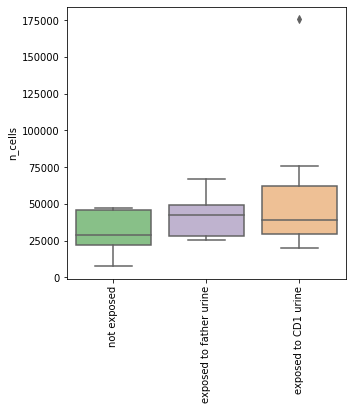

In [116]:
boxplot(make_dfs(dictionary_results=dict_results_across_mice, 
        experimental_groups=experimental_groups, 
        value='n_cells'), value='n_cells')

In [117]:
from scipy.stats import f_oneway

In [118]:
value = 'n_cells'
df = make_dfs(dictionary_results=dict_results_across_mice, 
        experimental_groups=experimental_groups, 
        value=value)
f_oneway(df[0][value].to_numpy(), df[1][value].to_numpy(), df[2][value].to_numpy())

F_onewayResult(statistic=1.1764422613616043, pvalue=0.3262535633030527)

In [119]:
value = 'energy'
df = make_dfs(dictionary_results=dict_results_across_mice, 
        experimental_groups=experimental_groups, 
        value=value)
f_oneway(df[0][value].to_numpy(), df[1][value].to_numpy(), df[2][value].to_numpy())

F_onewayResult(statistic=0.012096478615350337, pvalue=0.9879826707394277)

In [120]:
value = 'density'
df = make_dfs(dictionary_results=dict_results_across_mice, 
        experimental_groups=experimental_groups, 
        value=value)
f_oneway(df[0][value].to_numpy(), df[1][value].to_numpy(), df[2][value].to_numpy())

F_onewayResult(statistic=1.9283225267855373, pvalue=0.1681802062867833)

In [121]:
value = 'relative_density'
df = make_dfs(dictionary_results=dict_results_across_mice, 
        experimental_groups=experimental_groups, 
        value=value)
f_oneway(df[0][value].to_numpy(), df[1][value].to_numpy(), df[2][value].to_numpy())

F_onewayResult(statistic=1.882831472882243, pvalue=0.17487312071466152)